In [1]:
import sys
from pathlib import Path
from joblib import Parallel, delayed
sys.path.append("..\..")

from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

from src.data.matchers.intervals_matcher import IntervalsMelodyMatcher
from src.data.matchers.kmer_matcher import KMerMelodyMatcher
from src.data.matchers.minimizer_matcher import MinimizerMelodyMatcher
from src.data.matchers.offsets_matcher import OffsetsMelodyMatcher
from src.data.matchers.smith_waterman_matcher import SmithWatermanMelodyMatcher
from src.data.matchers.base_matcher import BaseMelodyMatcher
from src.data.structures.melody import Melody

In [2]:
LEVENSHTEIN_DISTANCE_THRESHOLDS = range(0, 101)

In [3]:
overlaping_pairs = []
non_overlaping_pairs = []

In [4]:
dataset_path = Path("..\\..\\datasets\\PlagiNet\\cases")

for case_dir in dataset_path.iterdir():
    if case_dir.is_dir():
        midi_files = list(case_dir.glob("*.mid"))
        overlaping_pairs.append((midi_files[0], midi_files[1]))

all_melodies = [midi for pair in overlaping_pairs for midi in pair]

for i, melody1 in enumerate(all_melodies):
    for melody2 in all_melodies[i+1:]:
        if melody1.parent != melody2.parent:
            non_overlaping_pairs.append((melody1, melody2))

In [5]:
def calculate_levenshtein_distances(matcher_class: BaseMelodyMatcher, pairs: list[tuple[Path, Path]]) -> list[float]:
    """Вычисляет расстояние Левенштейна для каждой пары мелодий.
    
    :param matcher_class: Алгоритм сравнения мелодий
    :param pairs: Список пар мелодий
    :return: Список расстояний Левенштейна
    """
    def process_pair(pair: tuple[Path, Path]) -> float:
        midi1_path, midi2_path = pair
        melody1 = Melody.from_midi(midi1_path)
        melody2 = Melody.from_midi(midi2_path)
        
        matcher = matcher_class(melody1, melody2)
        matcher.find_patterns()
        distance = matcher.overlaps_levenshtein_distance()

        return distance if distance != float('inf') else 1000
    
    distances = Parallel(n_jobs=-1, backend='loky')(
        delayed(process_pair)(pair) for pair in tqdm(pairs, desc="Calculating distances")
    )
    
    return distances

In [6]:
def get_roc_curve(overlaping_distances: list[float], non_overlaping_distances: list[float]) -> tuple[np.ndarray, np.ndarray]:

    y_true = np.concatenate([
        np.ones(len(overlaping_distances)),
        np.zeros(len(non_overlaping_distances))
    ])

    y_scores = -np.concatenate([
        overlaping_distances,
        non_overlaping_distances
    ])

    fpr, tpr, _ = roc_curve(y_true, y_scores)  

    return fpr, tpr

In [7]:
def calculate_metrics(
    overlaping_distances: list[float],
    non_overlaping_distances: list[float],
    thresholds: list[int],
    n_bootstrap: int = 1000,
    seed: int = 42
) -> dict[str, dict[str, list[float]]]:
    """Вычисляет precision, recall и auc с доверительными интервалами на разных порогах с помощью бутстрапа.

    :param list[float] overlaping_distances: Список расстояний Левенштейна для пар мелодий с пересечением
    :param list[float] non_overlaping_distances: Список расстояний Левенштейна для пар мелодий без пересечения
    :param list[int] thresholds: Список пороговых значений расстояний Левенштейна
    :param int n_bootstrap: Количество итераций бутстрапа
    :param int seed: Сид для генератора случайных чисел

    :return dict[str, dict[str, list[float]]]: Словарь с precision, recall, auc и roc
    """
    rng = np.random.default_rng(seed)
    metrics = {
        "precision": {"mean": [], "lower": [], "upper": []},
        "recall": {"mean": [], "lower": [], "upper": []},
        "auc": {"mean": None, "lower": None, "upper": None},
        "roc": {"fpr": [], "tpr_mean": [], "tpr_lower": [], "tpr_upper": []}
    }

    fpr_lin = np.linspace(0, 1, 100)
    tpr_boot = []
    aucs = []

    for _ in trange(n_bootstrap, desc="Calculating AUC with CI"):
        pos_sample = rng.choice(overlaping_distances, size=len(overlaping_distances), replace=True)
        neg_sample = rng.choice(non_overlaping_distances, size=len(non_overlaping_distances), replace=True)

        fpr_i, tpr_i = get_roc_curve(pos_sample, neg_sample)
        auc_val = auc(fpr_i, tpr_i)
        aucs.append(auc_val)

        interp_tpr = np.interp(fpr_lin, fpr_i, tpr_i)
        interp_tpr[0] = 0.0
        tpr_boot.append(interp_tpr)


    aucs = np.array(aucs)
    metrics["auc"]["mean"] = aucs.mean()
    metrics["auc"]["lower"] = np.percentile(aucs, 2.5)
    metrics["auc"]["upper"] = np.percentile(aucs, 97.5)

    tpr_boot = np.array(tpr_boot)
    metrics["roc"]["fpr"] = fpr_lin
    metrics["roc"]["tpr_mean"] = tpr_boot.mean(axis=0)
    metrics["roc"]["tpr_lower"] = np.percentile(tpr_boot, 2.5, axis=0)
    metrics["roc"]["tpr_upper"] = np.percentile(tpr_boot, 97.5, axis=0)

    for threshold in trange(len(thresholds), desc="Calculating precision and recall with CI"):
        boot_prec = []
        boot_rec = []

        for _ in range(n_bootstrap):
            pos_sample = rng.choice(overlaping_distances, size=len(overlaping_distances), replace=True)
            neg_sample = rng.choice(non_overlaping_distances, size=len(non_overlaping_distances), replace=True)

            tp = sum(1 for d in pos_sample if d <= threshold)
            fp = sum(1 for d in neg_sample if d <= threshold)
            fn = sum(1 for d in pos_sample if d > threshold)

            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0

            boot_prec.append(prec)
            boot_rec.append(rec)

        for name, vals in zip(["precision", "recall"], [boot_prec, boot_rec]):
            vals = np.array(vals)
            metrics[name]["mean"].append(vals.mean())
            metrics[name]["lower"].append(np.percentile(vals, 2.5))
            metrics[name]["upper"].append(np.percentile(vals, 97.5))

    return metrics

In [12]:
def visualize_metrics(metrics: dict, selected_matchers: dict):
    """Отображает метрики выбранных алгоритмов на одном графике.
    
    :param all_metrics: Словарь с метриками всех алгоритмов
    :param selected_matchers: Словарь с выбранными алгоритмами
    """
    colors = ['blue', 'green', 'red', 'purple', 'black']
    ci_alpha = 0.2

    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    for (matcher_class, matcher_title), color in zip(selected_matchers.items(), colors):
        matcher_metrics = metrics[matcher_class]
        
        mean_precision = matcher_metrics["precision"]["mean"]
        lower_precision = matcher_metrics["precision"]["lower"]
        upper_precision = matcher_metrics["precision"]["upper"]

        mean_recall = matcher_metrics["recall"]["mean"]
        lower_recall = matcher_metrics["recall"]["lower"]
        upper_recall = matcher_metrics["recall"]["upper"]

        mean_auc = matcher_metrics["auc"]["mean"]
        lower_auc = matcher_metrics["auc"]["lower"]
        upper_auc = matcher_metrics["auc"]["upper"]

        fpr = matcher_metrics["roc"]["fpr"]
        tpr_mean = matcher_metrics["roc"]["tpr_mean"]
        tpr_lower = matcher_metrics["roc"]["tpr_lower"]
        tpr_upper = matcher_metrics["roc"]["tpr_upper"]

        ax1.plot(LEVENSHTEIN_DISTANCE_THRESHOLDS, mean_precision, label=matcher_title, color=color)
        ax1.fill_between(LEVENSHTEIN_DISTANCE_THRESHOLDS, lower_precision, upper_precision, alpha=ci_alpha, color=color)
        
        ax2.plot(LEVENSHTEIN_DISTANCE_THRESHOLDS, mean_recall, label=matcher_title, color=color)
        ax2.fill_between(LEVENSHTEIN_DISTANCE_THRESHOLDS, lower_recall, upper_recall, alpha=ci_alpha, color=color)
        
        ax3.plot(fpr, tpr_mean, label=f"{matcher_title}\nAUC = {mean_auc:.2f} [{lower_auc:.2f}, {upper_auc:.2f}]", color=color)
        ax3.fill_between(fpr, tpr_lower, tpr_upper, alpha=ci_alpha, color=color)

    ax1.set_xlabel("Порог расстояния Левенштейна")
    ax1.set_ylabel("Точность")
    ax1.set_ylim((0, 1))
    ax1.legend()
    ax1.grid(True)
    ax1.set_title("Точность")

    ax2.set_xlabel("Порог расстояния Левенштейна")
    ax2.set_ylabel("Полнота")
    ax2.set_ylim((0, 1))
    ax2.legend()
    ax2.grid(True)
    ax2.set_title("Полнота")

    ax3.plot([0, 1], [0, 1], color="black", linestyle="--", alpha=0.5)
    ax3.set_xlabel("FPR")
    ax3.set_ylabel("TPR")
    ax3.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
    ax3.grid(True)
    ax3.set_title("ROC-кривая")

    plt.tight_layout()
    plt.show()

Calculating precision and recall with CI: 100%|██████████| 101/101 [00:08<00:00, 11.98it/s]


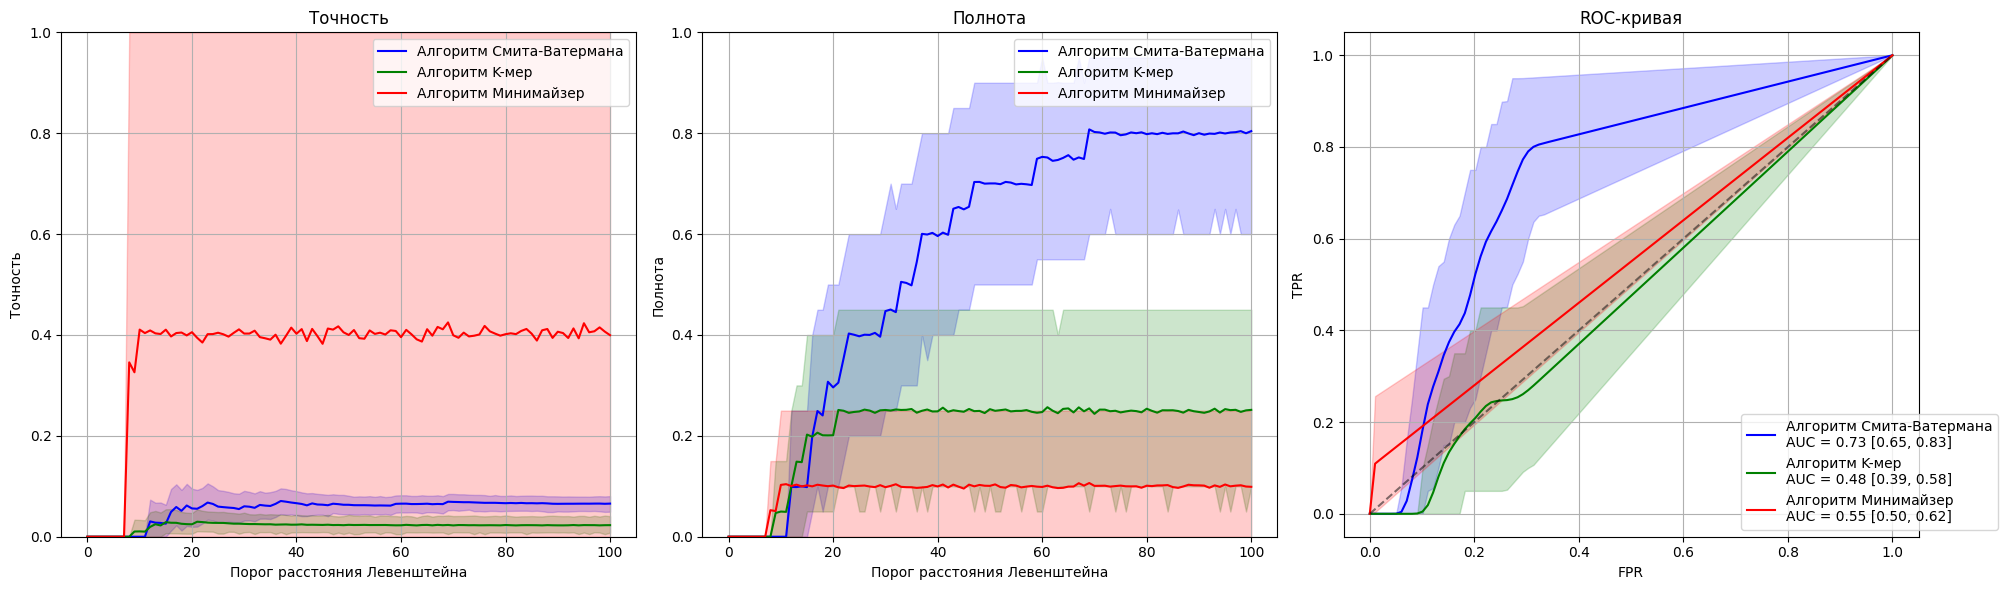

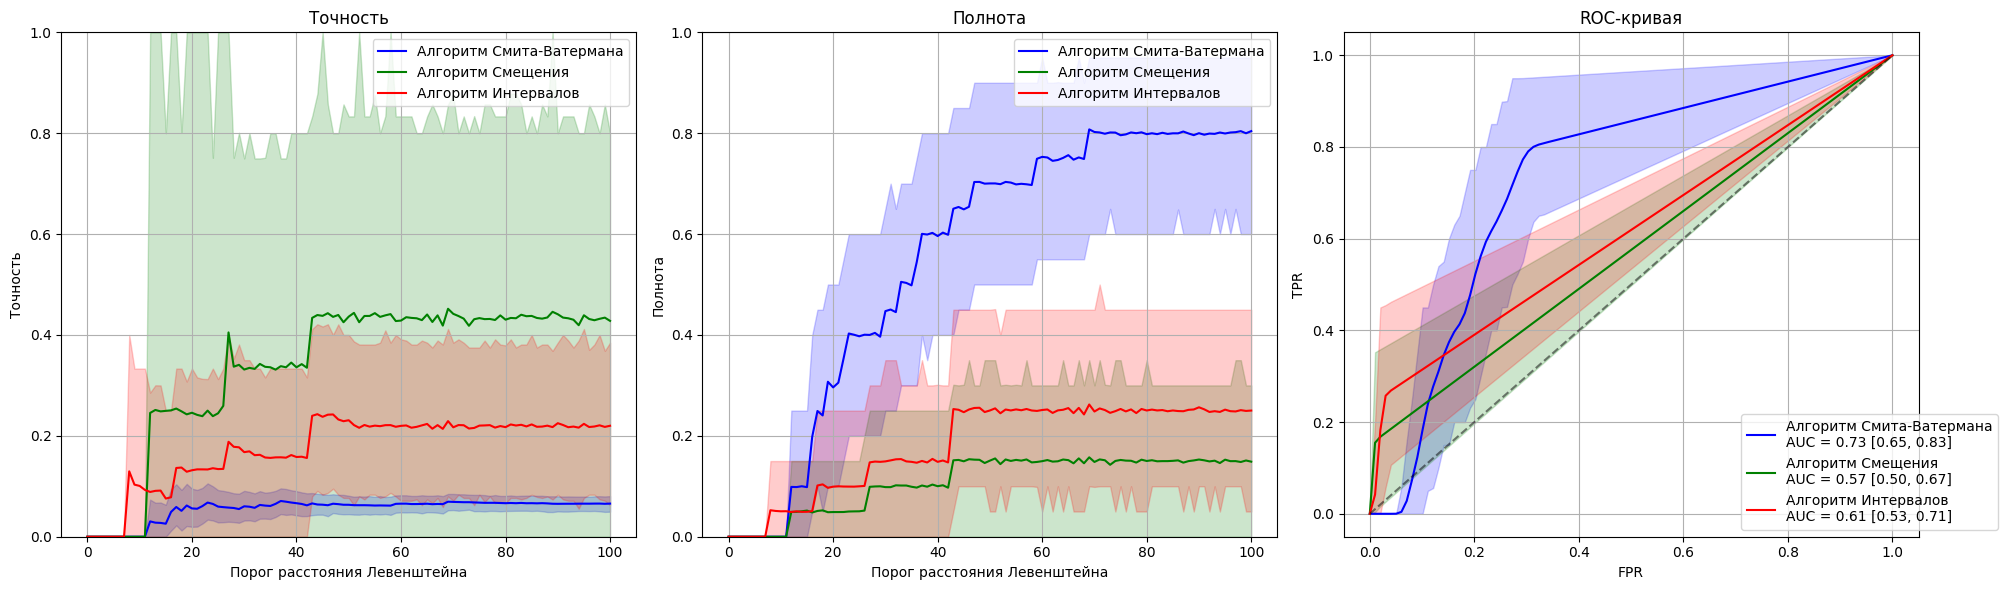

In [13]:
matchers = {
    SmithWatermanMelodyMatcher: "Алгоритм Смита-Ватермана", 
    KMerMelodyMatcher: "Алгоритм K-мер", 
    MinimizerMelodyMatcher: "Алгоритм Минимайзер", 
    OffsetsMelodyMatcher: "Алгоритм Смещения", 
    IntervalsMelodyMatcher: "Алгоритм Интервалов"
}

metrics = {}

for matcher_class in matchers:
    overlaping_distances = calculate_levenshtein_distances(matcher_class, overlaping_pairs)
    non_overlaping_distances = calculate_levenshtein_distances(matcher_class, non_overlaping_pairs)
    
    cur_metrics = calculate_metrics(
        overlaping_distances,
        non_overlaping_distances,
        thresholds=LEVENSHTEIN_DISTANCE_THRESHOLDS,
        n_bootstrap=1000
    )
    
    metrics[matcher_class] = cur_metrics

matchers_1 = {
    SmithWatermanMelodyMatcher: "Алгоритм Смита-Ватермана",
    KMerMelodyMatcher: "Алгоритм K-мер",
    MinimizerMelodyMatcher: "Алгоритм Минимайзер"
}

matchers_2 = {
    SmithWatermanMelodyMatcher: "Алгоритм Смита-Ватермана",
    OffsetsMelodyMatcher: "Алгоритм Смещения",
    IntervalsMelodyMatcher: "Алгоритм Интервалов"
}

visualize_metrics(metrics, matchers_1)
visualize_metrics(metrics, matchers_2)